In [8]:
from camo_worms_utils import *

In [9]:
class Camo_Worm_OLD:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')
    
    def edge_points (self, intervals, print_results=False):
        """
        Genenerates edge points around a worm, based on width
        """
        edge_points = []

        # Get Parallels returns two parallel lines separated by a width. 
        # This is not quite the true edge points as the end caps will be incorrect
        edge_points = np.array(
            mbezier.get_parallels(self.control_points(), self.width)
        )

        # The points returned are control points, not intermediate points.
        line1 = mbezier.BezierSegment(edge_points[0])
        line2 = mbezier.BezierSegment(edge_points[1])

        # Borrowed from the intermediate_points() method
        line1points = line1.point_at_t(np.linspace(0,1,intervals))
        line2points = line2.point_at_t(np.linspace(0,1,intervals))

        # Merge the two parallel lines into one continuous set of points:
        merged = np.concatenate((line1points, line2points), axis=0)

        if(print_results):
            print("control points: \n{}".format(self.control_points()))
            print("Edge Points: \n{}".format(merged))

        return merged

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))
    
    def coords_at_t(self, t):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))[0]
        return intermediates

    def colour_at_t(self, t, image):
        """
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        """
        point = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))[0]

        """
        # ignore points outside image
        xmin, xmax = [0, image.shape[0]]
        ymin, ymax = [0, image.shape[1]]
        if(    point[1] > xmin 
           and point[1] < xmax
           and point[0] > ymin
           and point[0] < ymax ):
            colours = image[point[1],point[0]] # reversed as [y, x]
            colour = np.array(colours)/255
            return colour
        else:
            return -1
        """
        # Coordinates are flipped in the next function
        x = point[0]
        y = point[1]

        return self.colour_at_xy(x, y, image)


    def colour_at_xy(self, x, y, image):

        #print("Colours at point: (x,y) = ({},{})".format(x, y))

        # ignore points outside image
        xmin, xmax = [0, image.shape[0]]
        ymin, ymax = [0, image.shape[1]]
        # Confusingly, point coordinates follow [x,y], while pixel matrix coords follow [y,x]
        if(    y > xmin 
           and y < xmax
           and x > ymin
           and x < ymax ):
            #print("xmin={} < y={} < xmax={}".format(xmin, y, xmax))
            #print("ymin={} < x={} < ymax={}".format(ymin, x, ymax))
            colours = image[y,x] # reversed as [y, x]
            #print("Colour = {}".format(colours))
            colour = np.array(colours)/255
            return colour
        else:
            return -1
    



    def print_variables(self):
        #print("[x,y,r,theta,dr,dgamma,width,colour]")
        print("[{x},{y},{r},{theta},{dr},{dgamma},{width},{colour}]".format(
            x = round(self.x, 2), 
            y= round(self.y, 2),
            r= round(self.r, 2),
            theta= round(self.theta, 2),
            dr= round(self.dr, 2),
            dgamma= round(self.dgamma, 2),
            width= round(self.width, 2),
            colour= round(self.colour, 2)
            )
        )
    
    def mate(self, partner):
        
        
        # 45% chance to pick one parent
        # 45% chance to pick other
        # 10% chance to mutate

        (radius_std, deviation_std, width_theta) = (40, 30, 1)
        (ylim, xlim) = image.shape
        
        #centerpoint coord x
        rand = rng.random() # 0 to 1
        if(rand < 0.45):       ch_x = self.x
        elif(rand < 0.9):      ch_x = partner.x
        else:                  ch_x = xlim * rng.random()
        #else:                  ch_x = (self.x + partner.x)/2

        #centerpoint coord y
        rand = rng.random()
        if(rand < 0.45):       ch_y = self.y
        elif(rand < 0.9):      ch_y = partner.y
        else:                  ch_y = ylim * rng.random()
        #else:                  ch_y = (self.y + partner.y)/2

        #radius
        rand = rng.random()       
        if(rand < 0.45):       ch_r = self.r
        elif(rand < 0.9):      ch_r = partner.r
        else:                  ch_r = radius_std * np.abs(rng.standard_normal())
        #else:                  ch_r = (self.r + partner.r)/2

        #angle from x axis
        rand = rng.random()        
        if(rand < 0.45):       ch_theta = self.theta
        elif(rand < 0.9):      ch_theta = partner.theta
        else:                  ch_theta = rng.random() * np.pi
        #else:                  ch_theta = (self.theta + partner.theta)/2

        # radius of deviation from midpoint
        rand = rng.random()        
        if(rand < 0.45):       ch_dr = self.dr
        elif(rand < 0.9):      ch_dr = partner.dr
        else:                  ch_dr = deviation_std * np.abs(rng.standard_normal())
        #else:                  ch_dr = (self.dr + partner.dr)/2

        #angle of line joining midpoint and curve
        rand = rng.random()        
        if(rand < 0.45):       ch_dgamma = self.dgamma
        elif(rand < 0.9):      ch_dgamma = partner.dgamma
        else:                  ch_dgamma = rng.random() * np.pi
        #else:                  ch_dgamma = (self.dgamma + partner.dgamma)/2

        #thickness
        rand = rng.random()        
        if(rand < 0.45):       ch_width = self.width
        elif(rand < 0.9):      ch_width = partner.width
        else:                  ch_width = width_theta * rng.standard_gamma(3)
        #else:                  ch_width = (self.width + partner.width)/2

        # worm colour - 0 to 255
        rand = rng.random()
        if(rand < 0.45):       ch_colour = self.colour
        elif(rand < 0.9):      ch_colour = partner.colour
        else:                  ch_colour = rng.random()
        #else:                  ch_colour = (self.colour + partner.colour)/2
        
        child = Camo_Worm(
            ch_x,
            ch_y,
            ch_r,
            ch_theta,
            ch_dr,
            ch_dgamma,
            ch_width,
            ch_colour
        )
        
        """
        print("Self:")
        self.print_variables()
        print("Partner:")
        partner.print_variables()
        print("Child:")
        child.print_variables()
        """
        
        return child


Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


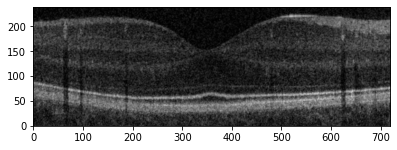

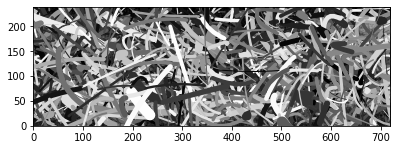

In [10]:
# Read, crop and display image and stats

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Initialise clew of 40 and draw

GENERATIONS = 15
POPULATION = 1000
PERCENT = 10

#clew = initialise_clew(40, image.shape, (40, 30, 1))
clew = initialise_clew(POPULATION, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

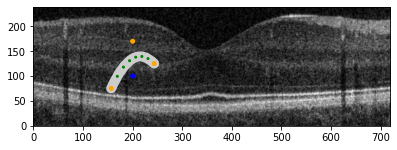

In [11]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')



drawing.show(save='bezier.png')

In [12]:
""" OLD METHOD
def average_distance(worm, clew):
    dists = []

    for i in range(len(clew)):
        # print("Distance: ({x1},{y1}) to ({x2},{y2})".format(x1=worm.x, y1=worm.y, x2=clew[i].x, y2=clew[i].y))
        euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
        # print(f"Worm centre ({worm.x}, {worm.y})")
        # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
        # print(f"Dist: {euclid_dist}")
        #print("euclid_dist:{}".format(euclid_dist))
        if(euclid_dist != 0):
            dists.append(euclid_dist)

        # don't bother checking if it's the same worm. It will just be a distance of 0.

    if(dists):  # not empty
        avg_dist = np.mean(dists)
    else:
        avg_dist = 0
        print("Nothing in list. Len={}".format(len(clew)))

    return avg_dist """


def count_overlaps(worm, clew):

    # count-based - get proportion of other worms "touching" this worm
    # define "touching" as dist to other point is less than this.width+other.width
    count = 0
    for i in range(len(clew)):
        if i is not worm_idx:
            # base off of three intermediate points
            # i.e. add one to count if any points are too close
            points_worm = worm.intermediate_points()
            points_other = clew[i].intermediate_points()
            
            combos = list(product(points_worm, points_other))

            for point_worm, point_other in combos:
                euclid_dist = np.linalg.norm(
                    np.array(point_worm)-np.array(point_other)
                )
                # print(f"Points {point_worm}, {point_other}")
                # print(f"Widths {worm.width}, {clew[i].width}")
                # print(f"Dist {euclid_dist}\n")
                if euclid_dist < worm.width + clew[i].width:
                    # theyre touching
                    count += 1
                    break

    proportion = count/(len(clew)-1)
    # print(f"Count: {count}, Proportion: {proportion}")

    return proportion


""" OLD METHOD
def average_colour_diff(worm, image):

    # Range of 10 t values to gather points for
    t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9, 1.0]

    #print(t_range)

    total_colour_diff = 0
    count = 0

    for t in t_range:
        image_colour = worm.colour_at_t( t, image )
        if(image_colour > -1): # If it returns -1, it means the point is outside the image
            count = count + 1
            total_colour_diff = total_colour_diff + abs(worm.colour - image_colour)
        else:
            # assume maximum difference as penalty
            count = count + 1
            total_colour_diff = total_colour_diff + 255

    #print(total_colour_diff)
    if(count > 0):
          colour_diff_ave = total_colour_diff/count # To get average, divide by 10 samples
    else: colour_diff_ave=0
    return colour_diff_ave """

""" def average_contrast(worm, image):
    # Gather points at boundary of worm to test
    total_contrast = 0
    count = 0

    for edge_point in worm.edge_points(5):
        # Get image colour at boundary
        x = round(edge_point[0])    # Only whole indexes are allowed
        y = round(edge_point[1])    # The maths that finds edge points can get decimals
        image_colour = worm.colour_at_xy( x, y, image)
        #print("Colour difference at (x,y)=({},{})\nWorm Colour = {}\nImage Colour ={}".format(x,y, worm.colour, image_colour))
        # Calculate contrast by comparing worm body colour with edge colour
        # Assume worm is similar colour to background because of score function
        total_contrast = total_contrast + abs(image_colour - worm.colour)
        count = count + 1

    if(count > 0):
          contrast_ave = total_contrast/count # To get average, divide by 10 samples
    else: contrast_ave=0
    return contrast_ave """

# a sorting function
def eval_worm(worm, clew_var=clew, image_var=image, size_weight=100, dist_weight=1300, colour_weight=1500, contrast_weight=150, print_results=False):
    # NOTE: image and clew is hardcoded, as variables can't be passed through sort(key=...)

    score = 0

    #contrast_weight=80
    
    # ------------ Internal Knowledge ------------
    
    # --- Size ---
    # Big Worms to counteract 1 pixel worms being highest score
    size = worm.approx_length() / image_var.shape[1] # size as a percentage of image width
    size_comp = size_weight*size
    
    
    # ------------ Group Knowledge ------------
    
    # --- Average Distance ---
    """old method
    #dist_weight=0.2
    #average_dist = average_distance(worm, clew_var)
    #dist_comp = dist_weight * average_dist 
    
    average_dist = average_distance(worm, clew_var)
    # option1
    # want worms spread out (add small constant to prevent divide by 0)
    # take min with 1 to keep on scale 0 to 1
    inversed = min(1/(average_dist+0.00001), 1)
    # define as 0 for some ideal distance apart (should define it better than max(image.shape))
    #if average_dist > max(image.shape):
    #    inversed = 0
    ## define as 1 for too far apart
    #if average_dist > max(image.shape)*1.05:
    ##    inversed = 1
    dist_comp = dist_weight * inversed
    """

    dist_comp = 0
    


    
    # ------------ Environmental Knowledge ------------

    # --- Colour Difference ---
    # Compare to colour (inverse)
    #colour_diff = average_colour_diff(worm, image_var)
    #colour_comp = colour_weight* -colour_diff
    colour_comp = 0

    # --- Contrast ---
    # Find hard edges around worm
    #contrast = average_contrast(worm, image)
    contrast = 0
    contrast_comp = contrast_weight*contrast


    # ------------ Final Calibration ------------

    # Sort doesn't work with decimals
    score = round( (size_comp + dist_comp + colour_comp + contrast_comp)*1000 )

    if(score < 0):
        score = 0 # No negatives allowed for sorting. Assume anything with a score of 0 will get discarded.

    if(print_results):
        print( "    Score: (sz={print_size}) + (dist={print_dist}) + (col={print_colour}) + (con={print_contrast}) = {print_score}".format(
            print_size=size_comp,
            print_dist = dist_comp,
            print_colour=colour_comp,
            print_contrast = contrast_comp,
            print_score = score) )
    
    return score

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


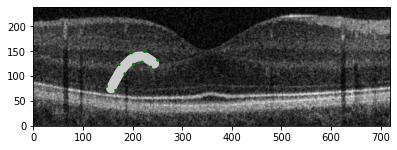

(240, 720)


In [13]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)

t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9]
print(t_range)

# coords = []
# for t in t_range:
#     print(worm.coords_at_t(t))
#     coords.append(  worm.coords_at_t(t) )

#print(coords)

drawing = Drawing(image)
drawing.add_worms(worm)
#drawing.add_dots(coords, radius=2, color='green')
drawing.add_dots(worm.edge_points(5), radius=2, color='green')

drawing.show(save='bezier.png')


print(image.shape)
# reversed as [y, x]

--------Generation 0------------
Test first 5 vals
    Score: (sz=31.9768266363062) + (dist=0) + (col=0) + (con=0) = 31977
    Score: (sz=31.541414402062195) + (dist=0) + (col=0) + (con=0) = 31541
    Score: (sz=30.16417486438052) + (dist=0) + (col=0) + (con=0) = 30164
    Score: (sz=29.868199896846807) + (dist=0) + (col=0) + (con=0) = 29868
    Score: (sz=29.703353229512015) + (dist=0) + (col=0) + (con=0) = 29703
Best Worm:
    Score: (sz=31.9768266363062) + (dist=0) + (col=0) + (con=0) = 31977


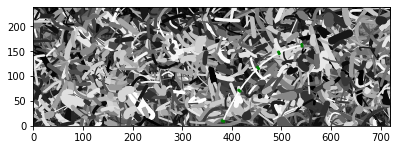

Average Score: 9754.645


NameError: name 'image' is not defined

In [14]:
""" class Clew:
    def __init__(self, clew, image):
        self.clew = clew
        self.image = image
    def sort(self):
        self.clew """



# hardcode 10 generations
for gen in range(GENERATIONS):

    print("--------Generation {}------------".format(gen))
    
    # sort in order with a scoring function

    clew = sorted(clew, key=eval_worm, reverse=True) # this will only work because eval_worm has one argument
    # clew.sort(key= eval_worm) # this will only work because eval_worm has one argument
    # clew.reverse() # need to reverse because higher numbers get put at bottom

    # Test of first 5 values
    print("Test first 5 vals")
    for i in range(5):
        current_worm = clew[i]
        score = eval_worm(current_worm, print_results=True)

    drawing = Drawing(image)
    drawing.add_worms(clew)

    best_worm = clew[0]
    print("Best Worm:")
    eval_worm(best_worm, print_results=True)
    #print("    Best environment worm point: x %2d, y %2d" %(best_worm.x, best_worm.y))
    #print("    Length: %.2f, width %.2f and colour: %.2f" % (best_worm.approx_length(), best_worm.width, best_worm.colour* 255 ))
    drawing.add_worms(best_worm) # put it on top
    #drawing.add_dots(best_worm.intermediate_points(5), 2, color="orange")
    drawing.add_dots(best_worm.edge_points(5), 2, color="green")

    drawing.show()
    
    n = 0
    total = 0
    for worm in clew:
        #score = eval_worm(worm, print_results=True)
        score = eval_worm(worm)
        #print(score)
        n += 1
        total += score
    ave=total/n
    print("Average Score: {}".format(ave))
    
    
    # get top 10% to start next generation
    ten_perc = round( (PERCENT/100) * POPULATION )

    new_clew = []
    for i in range(ten_perc):
        new_clew.append( clew[i] )
    
    # use top 10% to generate the rest of the population
    # ------------- TO FIX: CURRENTLY BOTH PARENTS CAN BE SAME ------------------
    
    for i in range( POPULATION - ten_perc ): # get remaining 90% of pop
    
        rand1 = rng.integers(0, ten_perc) # pick one of the top 10%
        parent1 = clew[rand1]

        rand2 = rng.integers(0, ten_perc)
        parent2 = clew[rand2]

        child = parent1.mate(parent2, image)
        new_clew.append(child)
    
    # replace the previous generation
    clew = new_clew
    
    #print(len(clew))
    
    

&copy; Cara MacNish, UWA, 2024